<a href="https://colab.research.google.com/github/NorsemanO/DL-Seneca/blob/master/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# Project 3: Implementing a Simple Recurrent Neural Network (RNN)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Convolutional Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.


In [ ]:
import cv2 as cv
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
print("PyTorch version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available for PyTorch!")
else:
    print("No GPU found for PyTorch.")

PyTorch version: 2.3.0+cu121
No GPU found for PyTorch.


In [ ]:
csv_path = "/jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [ ]:
# See if there is any empty value in the dataset
df.isnull().values.any()

False

In [ ]:
# Convert Data Time to datetime format and set it as index
df['Date Time'] = pd.to_datetime(df['Date Time'], format='mixed')
df = df.set_index('Date Time')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


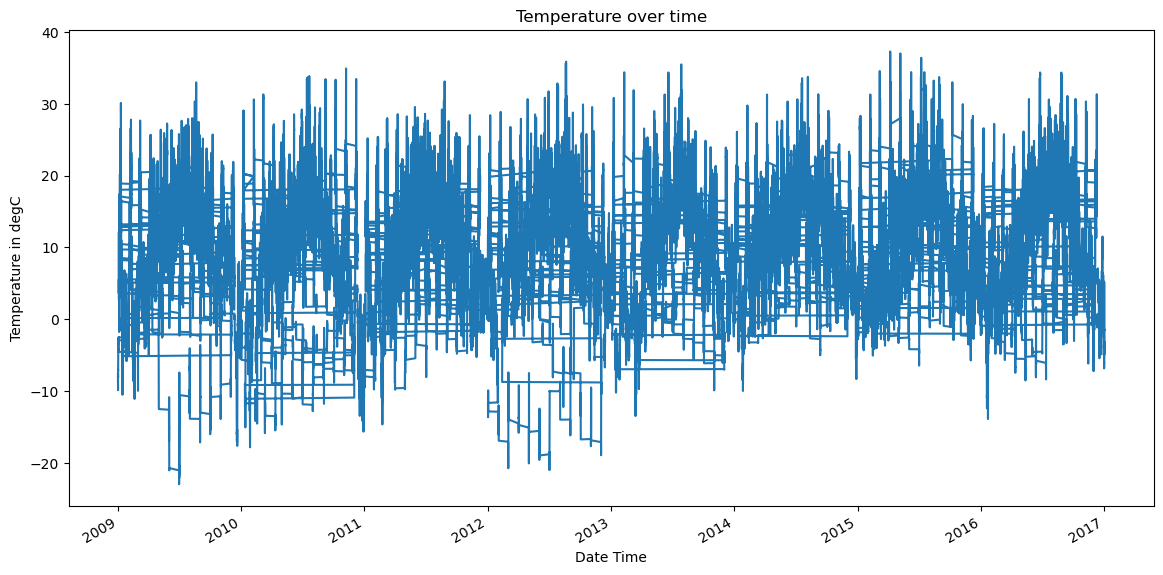

In [ ]:
# Plot the temperature over time in Celsius
plt.figure(figsize=(14,7))
df['T (degC)'].plot()
plt.title('Temperature over time')
plt.xlabel('Date Time')
plt.ylabel('Temperature in degC')
plt.show()

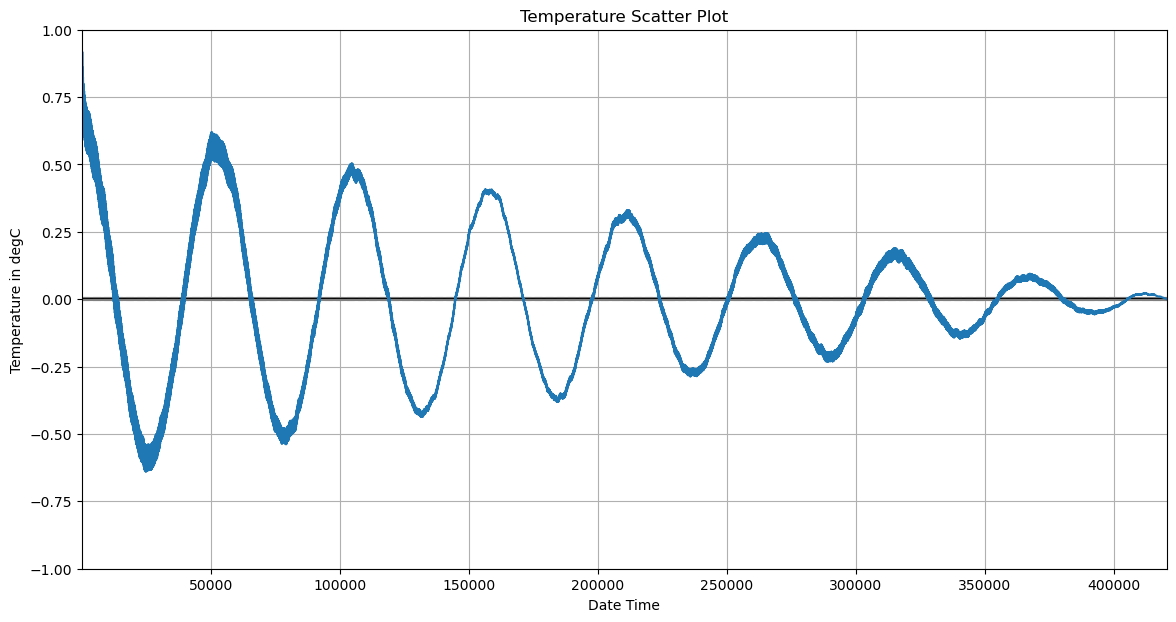

In [ ]:
# Autrocorrelation plot

plt.figure(figsize=(14,7))
pd.plotting.autocorrelation_plot(df['T (degC)'])
plt.title('Temperature Scatter Plot')
plt.xlabel('Date Time')
plt.ylabel('Temperature in degC')
plt.show()

In [ ]:
# Using only the temperature column to make predictions of temperature as time changes.
df=df['T (degC)']

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(df.values.reshape(-1, 1))

In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 12
X, y = create_sequences(data_normalized, seq_length)

# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

In [ ]:
train_size = int(len(X) * 0.75)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTM, self).__init__()
        # Number of features in the input
        self.hidden_layer_size = hidden_layer_size
        # LSTM layer with input size (features) and hidden layer size (units)
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        # Fully connected linear layer that maps from hidden state to output
        self.linear = nn.Linear(hidden_layer_size, output_size)
        # Initialize hidden state and cell state with zeros
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        # input_seq.view is to reshape the input sequence for the LSTM layer
        # LSTM layer's expected input shape: (sequence_length, batch_size, input_size). Here, `sequence_length` is the length of the input sequence, `batch_size` is set to 1, and `input_size` is the number of features (1 in this example).
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        # lstm_out.view is to reshape the LSTM output for the linear layer
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        # Index -1 is to return the last prediction in the sequence
        return predictions[-1]


In [ ]:
model = LSTM()
model.cuda()
print(model)

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
model = LSTM()
model.cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10

for i in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                        torch.zeros(1, 1, model.hidden_layer_size).cuda())

        seq=seq.cuda()
        labels=labels.cuda()

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')


epoch:   0 loss: 0.00007003
epoch:   9 loss: 0.0000265513


Root Mean Squared Error: 3.4770005137489606
Mean Absolute Percentage Error: 54482.96454573087


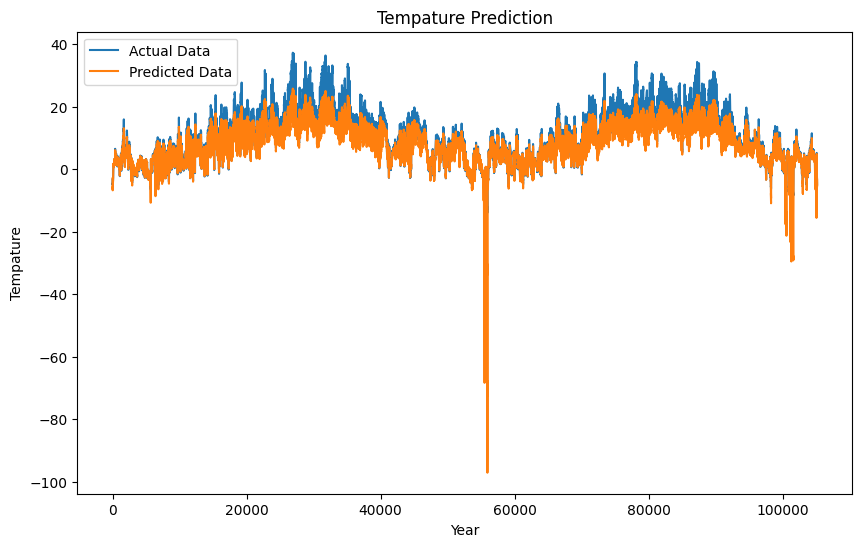

In [ ]:
model.eval()
test_outputs = []

for seq in X_test:
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                            torch.zeros(1, 1, model.hidden_layer_size).cuda())
        seq=seq.cuda()
        test_outputs.append(model(seq).item())

test_outputs = scaler.inverse_transform(np.array(test_outputs).reshape(-1, 1))
actuals = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actuals, test_outputs))
print(f'Root Mean Squared Error: {rmse}')

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(actuals, test_outputs)
print(f'Mean Absolute Percentage Error: {mape}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Data')
plt.plot(test_outputs, label='Predicted Data')
plt.title('Tempature Prediction')
plt.xlabel('Year')
plt.ylabel('Tempature')
plt.legend()
plt.show()

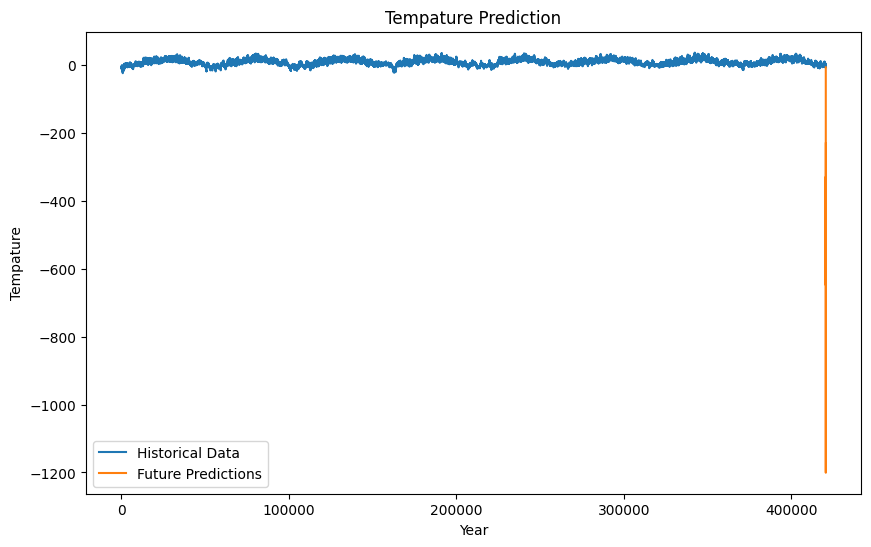

In [ ]:
def predict_future(model, data, future_periods, seq_length):
    predictions = data[-seq_length:].tolist()
    predictions = [item for sublist in predictions for item in sublist]  # Flatten the list
    model.eval()
    for _ in range(future_periods):
        seq = torch.FloatTensor(predictions[-seq_length:])
        with torch.no_grad():
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).cuda(),
                                torch.zeros(1, 1, model.hidden_layer_size).cuda())
            seq=seq.cuda()
            predictions.append(model(seq).item())
    return predictions[seq_length:]

# Predict future values
future_periods = 12
predictions = predict_future(model, data_normalized, future_periods, seq_length)
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(data_normalized), label='Historical Data')
plt.plot(np.arange(len(data_normalized), len(data_normalized) + future_periods), predictions, label='Future Predictions')
plt.title('Tempature Prediction')
plt.xlabel('Year')
plt.ylabel('Tempature')
plt.legend()
plt.show()

---
### Questions
Answer the following questions in detail.

1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.

    Answer: RNN is a neural Network that has hidden state that's capable to remember previous state.  It has the usual input and output layer.  The difference is in the Hidden layer.  The hidden states has memory that capture the weights of the previous state and add that into the calculation for the weight of the current state.



2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?

    Answer:  The purpose of the recurrent connection is to pass the hidden state memory into the current state. It enable the network to see pattern in the sequential data by remember previous state data and taking it into account when calcualting current state weights.



3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?

    Answer: Vanishing and exploding gradients are when gradients for the loss function become either very small, which means the model is no longer learning. Or when the gradients become exponentially big which makes the model hard to learn.  Those arise because of the many backpropgation steps the gradient go through which makes it can make it either small or big.



4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?

    Answer:  LSTM is type of RNN that address the problem arise from the basic RNN.  It has all the component of RNN, in addition, it has cell state that carry the memory through the steps, modify by the gates. The gates include input gates, forget gates and output gates that controls the cell states include, drops and outputs.  The gates decide what state to keep, and what drop, which limit the amount and flow of gradience that's used which would solve the vanishing and exploding gradients problem.



5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.

    Answer:  GRU is a simplify LSTM, the GRU determine how much the current state is being updated by past state and how much to forget.  It only has update gate and reset gate for determine how much to forget and does not maintain internal cell state.  Whereas LSTM has 3 gates and include the internal cell states.



6. Explain the role of the hidden state in an RNN. How is it updated during the training process?

    Answer: The hidden state is how RNN remembers the previous state.  It is updated using previous hidden state and current input using a non-linear activation function.  In the training process, the hidden state is compute through the forward pass, then combine it with the input to calculate output which is compare to the target value, compute the loss and change the weight, which include the hidden state weight, to minimize loss before being pass to the next step.



7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?

    Answer:  For time series forecasting, Mean Squared Error (MSE) and Mean Absolute Error (MAE) is great metric to use for evalutate the model success.  For sequential labelling for language, F1 score with percision and recall is great for understand the model success.



8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.

    Answer: For time series normalization and scaling of the data will greatly improve speed and efficience of training.  Fill in the missing values either as mean, max, min or sequence time data will also make the training more efficient.  For text, lower case text, tokenization, stemming/lemmingization, stop word removal and vectorization of text will also efficiently train the data.



9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?

    Answer: seq2seq is a type of architecture in RNN , it has encoding and decoding sequence and each sequence is implemented using RNN.  It's mostly used for language translation.  



10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.

    Answer: Since RNN is really good a recognizing patterns in time series data.  A RNN can be trained on a time series data with to recognize patterns with pre-set allowable threshold of deviation.  Then use the model to classify data points as inside or outside of the allowable threshold.  Thus anything that's classify as outside would be anomies.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.